# Take Home #1
## Pavel Muñoz and Javier Silva
### 04/28/2022

# Introduction
The chosen dataset was Medical Cost Personal Datasets. 
This dataset contains health insurance information of a group of people in the US.The columns are as follows:
Age, Sex, Bmi (Body mass index), Children, Smoker, Region, Charges.
The proposed model uses the independent variables "bmi" and "age" to try to explain how they affect the insurance payment, that is, how it affects the variable "charges". This will be our dependent variable.

## Dataset

First of all, we import all the libraries that we are going to use in our model. Then we import the data to build our model.

In [1]:
import pystan
import arviz as az
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
data = pd.read_csv("insurance.csv")
print(data.shape)
data.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


##  Analysis of variables
Before building the model, we have to analyze the variables themselves.

C:\Users\javie\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='charges'>

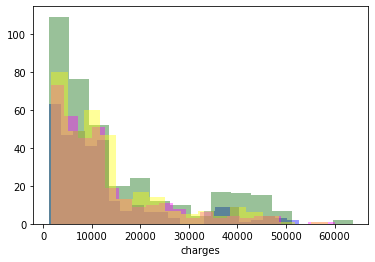

In [3]:
sns.distplot(data[data['region']=='southwest']['charges'],color="blue", label="southwest",kde=False)
sns.distplot(data[data['region']=='southeast']['charges'],color="darkgreen", label="southeast",kde=False)
sns.distplot(data[data['region']=='northwest']['charges'],color="magenta", label="northwest",kde=False)
sns.distplot(data[data['region']=='northeast']['charges'],color="yellow", label="northeast",kde=False)

We plot the variable "charges" grouped by region to see if there is a relationship between these two variables.

When analyzing the graphs superficially, it is established that the value of the insurance does not depend on the region, or at least it is not the factor that most affects the amount of the insurance.
Since the only two independent variables that are numeric are bmi and age, we will analyze and use them for the model.

<AxesSubplot:xlabel='bmi', ylabel='Count'>

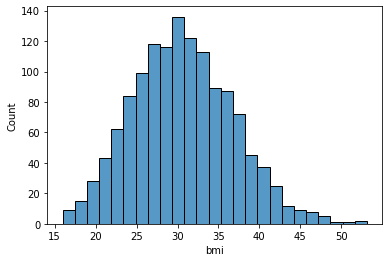

In [4]:
sns.histplot(data['bmi']) 

In [5]:
print("       media          /       desv_est    ")
print(np.mean(data["bmi"]),"/",np.std(data["bmi"]))

       media          /       desv_est    
30.663396860986538 / 6.095907641589428


We plot the variable "bmi" to analyze its distribution.
As we can see, the variable bmi has a kind of normal distribution with mean = 30 and standard deviation = 6.

<AxesSubplot:xlabel='age', ylabel='Count'>

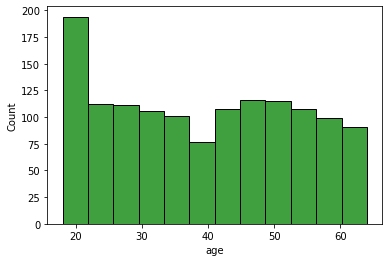

In [6]:
sns.histplot(data['age'], color="green") 

In [7]:
print("min / max")
print(np.min(data["age"]),"/ ",np.max(data["age"]))

min / max
18 /  64


Doing a similar analysis with the variable "age" and plotting, we see that it is uniformly distributed with a minimum of 18 and a maximum of 64.

## Building the model

Then we define our model and its components, such as the data, the parameters, and the model itself.
This is our 2-variable model:
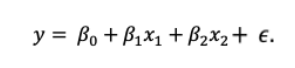
Our dependent variable y is "charge" and it is normally distributed. x1 is the independent variable "bmi" and x2 is the independent variable "age". The distributions of the last two variables are those described earlier in the document.
Finally we have the parameters for the variables. b0 is the intercept of the model, b1 and b2 are the regression coefficients of the independent variables x1 and x2, respectively.

In [8]:
sns.set()  # Nice plot aesthetic
np.random.seed(101)

model = """
data {
    int<lower=0> N;
    vector[N] y;
    vector[N] x1;
    vector[N] x2;
}
parameters {
    real b0;
    real b1;
    real b2;
    real<lower=0> sigma;
}
model {
    x1 ~ normal(30,6);
    x2 ~ uniform(18,64); 
    y ~ normal(b0 + b1 * x1 + b2 * x2 , sigma);
}
"""
# Parameters to be inferred
b0 = 4.0
b1 = 0.5
b2 = 3.0 
sigma = 1.0

# Generate and plot data
x1 = data['bmi']
x2 = data['age']
y = b0 + b1*x1 + b2*x2
y = data['charges']

In [9]:
# Put our data in a dictionary
data = {'N': len(y), 'y': y ,'x1': x1, 'x2':x2} 

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4d0f519d644346d8cfe73a92f03d7ade NOW.


## Model output

In [10]:
print(fit.stansummary())

Inference for Stan model: anon_model_4d0f519d644346d8cfe73a92f03d7ade.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b0     -6516   59.67 1771.1 -1.0e4  -7681  -6416  -5352  -3196    881    1.0
b1    335.54    1.57  51.65 237.19 300.44 334.13 371.84 436.11   1076    1.0
b2    242.48    0.67  22.76 198.89  227.7 242.21  257.0 291.36   1138    1.0
sigma  1.1e4    5.38 216.82  1.1e4  1.1e4  1.1e4  1.2e4  1.2e4   1625    1.0
lp__  -1.3e4    0.05   1.46 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4    713    1.0

Samples were drawn using NUTS at Fri Apr 29 00:01:54 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


We then print the model summary to analyze the values.
The intercept of the model, b0, is -6.516.
The regression coefficients b1 and b2 are 335.54 and 242.46, respectively.
Also, we have the value of sigma, which is 11,000, that represents the error in the model.
#### With that, the model is it as follows:
#### y = b0 + b1 * x1 + b2 * x2 +  ϵ
#### charges = - 6.516 + 335.54 * x1 + 242.46 * x2 + 11.000
If we see, the value of Rhat for all the parameters is equal to 1, which indicates that the chains must converge. 
We also have the value n_eff for all parameters, which indicates the effective sample size.



## Diagnosis with Arviz

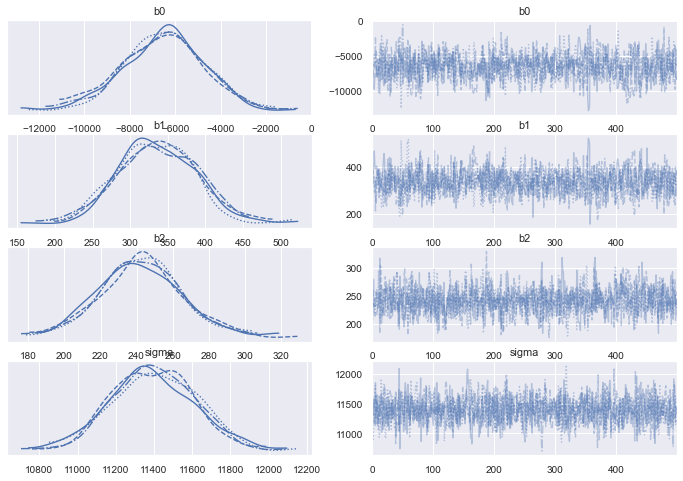

In [11]:
ax = az.plot_trace(fit, var_names=["b0","b1","b2","sigma"])

The chains that are thick-haired are those that indicate good mixing. Therefore, the graphs ordered from greatest to worst are b1, sigma, b2 and last b0.